# Regularization

The main task of this assignment is to create a Lasso regression model that uses the 101 predictors to predict the total number of non-violent crimes. In particular, you will need to implement the following three methods to determine the best hyperparameters to use:

In [ ]:
# %%
# imports
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### User Defined Funtions

In [2]:
def gen_lambdas(lambdas_range: tuple):
    """ 
    lambdas_range: tuple(min, max, n_inbetween)

    returns logspace of lambdas and linspace as index 
    """
    lambdas = np.logspace(lambdas_range[0], lambdas_range[1], lambdas_range[2])
    lambdas_index = np.linspace(
        lambdas_range[0], lambdas_range[1], lambdas_range[2])

    return lambdas, lambdas_index


In [3]:
def scale_set(x_fit, x_set, x_columns_values=None):
    """  """
    scaler = StandardScaler()
    scaler.fit(x_fit)

    X_fit = pd.DataFrame(scaler.transform(x_fit))
    X_set = pd.DataFrame(scaler.transform(x_set))

    if x_columns_values is not None:
        X_fit.columns = x_columns_values
        X_set.columns = x_columns_values

    return X_fit, X_set


In [4]:
def run_Lasso(X_train, y_train, X_test, y_test, lam, tol=None):
    """  """
    if tol is None:
        tol = 1e-4

    lm_lasso = linear_model.Lasso(alpha=lam, tol=tol)
    lm_lasso.fit(X_train, y_train)
    mse = mean_squared_error(lm_lasso.predict(X_test), y_test)

    return mse


In [5]:
def train_kLasso(X_train, y_train, lambdas_range, k=5):
    """  """
    # Getting Lambdas
    lambdas, lambdas_index = gen_lambdas(lambdas_range)
    # print(lambdas, lambdas_index)

    # Avg validation MSE of each hyperparameter candidate
    validation_mse = []

    for idx, lam in enumerate(lambdas):
        tmp_mse = []

        kfold = KFold(n_splits=k, shuffle=True, random_state=idx)
        for train_idx, valid_idx in kfold.split(X_train):
            # Training set
            X_training, Y_training = X_train.iloc[train_idx], y_train.iloc[train_idx]
            # Validation set
            X_validation, Y_validation = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # Scaling
            X_training, X_validation = scale_set(X_training, X_validation)

            # Lasso
            mse = run_Lasso(X_training, Y_training,
                            X_validation, Y_validation, lam)
            tmp_mse.append(mse)

        # Calculating avg MSE across the k-folds
        validation_mse.append(np.mean(tmp_mse))

    # Plotting the MSEs scores
    plot_MSE(lambdas_index, validation_mse)

    # Best Lambda
    bestLambda = lambdas[np.argmin(validation_mse)]
    print("Best Lambda: ", bestLambda)

    return bestLambda


In [6]:
def train_kLasso_tol(X_train, y_train, lambdas_range, k=5):
    # Getting Lambdas
    lambdas, lambdas_index = gen_lambdas(lambdas_range)
    # print(lambdas, lambdas_index)

    # Avg validation MSE of each hyperparameter candidate
    validation_mse = []

    tolerances = np.logspace(-10, 10, 21)

    # Define variables to keep track of best parameter and score
    best_params = ()
    best_mse = float('-inf')
    mse_scores = {}

    kfold = KFold(n_splits=k, shuffle=True)
    for lam in lambdas:
        for tol in tolerances:
            tmp_mse = []

            # Perform K-Fold CV
            for train_idx, valid_idx in kfold.split(X_train):
                # Training set and Validation set
                X_training, Y_training = X_train.iloc[train_idx], y_train.iloc[train_idx]
                X_validation, Y_validation = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

                # Scaling
                X_training, X_validation = scale_set(X_training, X_validation)

                # Lasso
                mse = run_Lasso(X_training, Y_training,
                                X_validation, Y_validation, lam, tol)
                
                tmp_mse.append(mse)
            
            # Calculate the mean of the scores across all folds
            mean_mse = np.mean(tmp_mse)
            mse_scores[(lam, tol)] = mean_mse

            # Update the best score and parameters if this model is better
            if mean_mse > best_mse:
                best_mse = mean_mse
                best_params = {'Lambda': lam, 'Tolerance': tol}

    # Plotting the MSEs scores
    # plot_MSE(lambdas_index, validation_mse)

    print("Best params: ", best_params)

    return best_params


In [7]:
def plot_MSE(lambdas_index, validation_mse):
    """  """
    plt.plot(lambdas_index, validation_mse)
    plt.xlabel('Lambda Value (log scale)')
    plt.ylabel('Averaged Validation MSE')
    plt.title('Validation MSE vs Lambda')
    plt.show()
    

In [8]:
def test_Lasso(X_train, y_train, X_test, y_test, lam):
    """  """
    # Scaling
    X_train_s, X_test_s = scale_set(X_train, X_test, X_train.columns.values)

    # Lasso Model
    lm_lasso = linear_model.Lasso(alpha=lam)
    lm_lasso.fit(X_train_s, y_train)

    # Results: Coefficients and MSE
    coef_ = pd.DataFrame(list(zip(X_train_s.columns, lm_lasso.coef_)), columns=[
                         ["Feature", "Coefficient"]])
    mse = mean_squared_error(lm_lasso.predict(X_test_s), y_test)

    return coef_, mse


## Lasso Models

In [15]:
# Loading data into DataFrame
community = pd.read_csv("community.csv")
community.head()

# Predictors
X = community.copy()
X = X.drop(["nonViolPerPop"], axis=1)

# Response
y = community["nonViolPerPop"]

# %%%
# HOLD OUT SET
# ------------

RND_STATE = 1
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RND_STATE)

# %%%
# GENERATING LAMBDAS RANGE
# ------------------------

lambdas_range = (0, 10, 201)  # returns lambdas, lambda_index


### OLS

In [16]:
X_int = sm.add_constant(X_train_valid)
lm = sm.OLS(y_train_valid, X_int).fit()
X_test_int = sm.add_constant(X_test)
# print(lm.summary())
print(lm.params)
print("MSE: ", mean_squared_error(lm.predict(X_test_int), y_test))

const                 -19228.550372
population                 0.025663
householdsize          -1303.552819
racepctblack              42.956757
racePctWhite              33.323651
                           ...     
PctSameState85             2.066174
LandArea                  -0.908292
PopDens                   -0.097189
PctUsePubTrans           -27.010127
LemasPctOfficDrugUn       55.518971
Length: 102, dtype: float64
MSE:  3682186.3088420113


### Train-Validation Test

In [17]:
# Second Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                      test_size=0.25,
                                                      random_state=RND_STATE)
mse_train = []
for lam in lambdas_range:
    mse = run_Lasso(X_train, y_train, X_valid, y_valid, lam)
    mse_train.append(mse)

bestLambda = lambdas_range[np.argmax(mse_train)]
test_Lasso(X_train, y_train, X_test, y_test, bestLambda)

(                 Feature Coefficient
 0             population    0.000000
 1          householdsize   -0.000000
 2           racepctblack    0.000000
 3           racePctWhite   -0.000000
 4           racePctAsian    0.000000
 ..                   ...         ...
 96        PctSameState85   -0.000000
 97              LandArea    0.000000
 98               PopDens   -0.000000
 99        PctUsePubTrans   -0.000000
 100  LemasPctOfficDrugUn  159.062015
 
 [101 rows x 2 columns],
 4006445.6772699477)

### 5-Fold Cross Validation

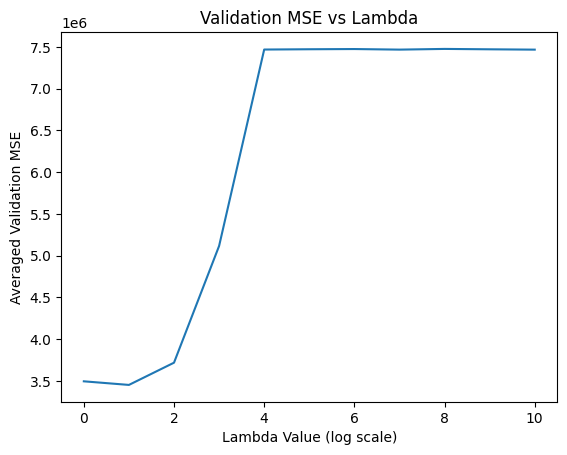

Best Lambda:  10.0


(                 Feature Coefficient
 0             population   -0.000000
 1          householdsize -222.039462
 2           racepctblack   88.380583
 3           racePctWhite    0.000000
 4           racePctAsian    0.000000
 ..                   ...         ...
 96        PctSameState85  -30.835650
 97              LandArea  -20.478631
 98               PopDens -256.053326
 99        PctUsePubTrans  -95.296378
 100  LemasPctOfficDrugUn  158.182358
 
 [101 rows x 2 columns],
 3479861.2189653176)

In [21]:
lambdas_range = (0, 10, 11)
bestLambda = train_kLasso(X_train_valid, y_train_valid, lambdas_range, k=5)
test_Lasso(X_train_valid, y_train_valid, X_test, y_test, bestLambda)


### 10-Fold Cross Validation

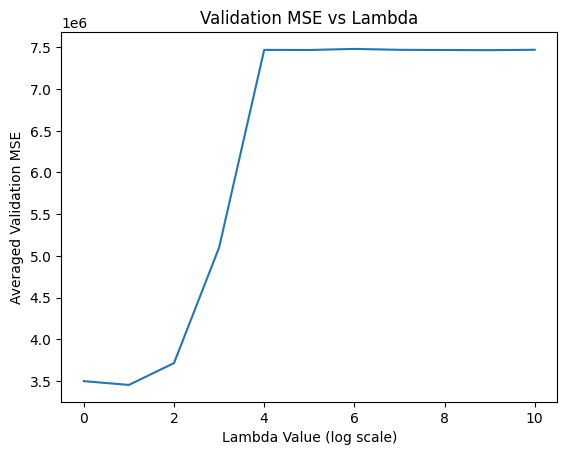

Best Lambda:  10.0


(                 Feature Coefficient
 0             population   -0.000000
 1          householdsize -222.039462
 2           racepctblack   88.380583
 3           racePctWhite    0.000000
 4           racePctAsian    0.000000
 ..                   ...         ...
 96        PctSameState85  -30.835650
 97              LandArea  -20.478631
 98               PopDens -256.053326
 99        PctUsePubTrans  -95.296378
 100  LemasPctOfficDrugUn  158.182358
 
 [101 rows x 2 columns],
 3479861.2189653176)

In [22]:
lambdas_range = (0, 10, 11)
bestLambda = train_kLasso(X_train_valid, y_train_valid, lambdas_range, k=10)
test_Lasso(X_train_valid, y_train_valid, X_test, y_test, bestLambda)
